In [1]:
%load_ext autoreload
import datetime
# import ete3
import itertools
import json
import logging
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import typing
# import re
import xml.etree.ElementTree as ET
# import xml.dom.minidom
# import xmlschema

In [ ]:
%autoreload
from maxes.xes_loader2 import XesLoader, XesLog
# from maxes.xes_file import XesFile
# from maxes.analyze_xes import AnalyzeXes
# import maxes.analyze_sequence
# import maxes.serialization.serialize
# import maxes.graphs
import maxes.notebooks.utils
import maxes.utils

In [ ]:
maxes.notebooks.utils.init_notebook() # RUN ONLY ONCE

In [5]:
file_path = maxes.notebooks.utils.get_data_path("other/simple.xes")
log = maxes.notebooks.utils.load_xes(file_path)
log.df

,call centre,org:resource,time:timestamp,lifecycle:transition,concept:name,location,duration,outcome
0,Brisbane,customer,1970-01-01 00:00:00+00:00,complete,incoming claim,NaN,NaN,NaN
1,NaN,Call Centre Agent Brisbane,1970-01-01 00:00:00+00:00,start,B check if sufficient information is available,Brisbane,NaN,NaN
2,NaN,Call Centre Agent Brisbane,1970-01-01 00:00:41+00:00,complete,B check if sufficient information is available,Brisbane,NaN,NaN
3,NaN,Call Centre Agent Brisbane,1970-01-01 00:00:41+00:00,start,B register claim,NaN,NaN,NaN
4,NaN,Call Centre Agent Brisbane,1970-01-01 00:12:59+00:00,complete,B register claim,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4,NaN,Call Centre Agent Sydney,1970-01-01 02:39:31+00:00,complete,S register claim,NaN,NaN,NaN
5,NaN,Claims handler,1970-01-01 06:56:04+00:00,start,determine likelihood of claim,NaN,NaN,NaN
6,NaN,Claims handler,1970-01-01 06:56:35+00:00,complete,determine likelihood of claim,NaN,NaN,NaN
7,NaN,Claims handler,1970-01-01 06:56:35+00:00,start,end,NaN,17306,not liable


In [6]:
%autoreload
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from maxes.generators.xes_generator.xes_generator3 import XesGenerator3, XesAttributeModelPredictor

model_prototype = Pipeline(steps=[
    ("column selector", ColumnTransformer([
        ("concept_name", OneHotEncoder(), ["concept:name"]),
        ("lifecycle_transition", OneHotEncoder(), ["lifecycle:transition"])
    ])),
    ("classifier", MLPClassifier())
])

xes_generator = XesGenerator3(
    attributes_models=[
        XesAttributeModelPredictor(
            attribute="org:resource",
            dependent_attributes=["concept:name", "lifecycle:transition"],
            model=clone(model_prototype),
            output_transformer=OneHotEncoder()
        ),

        XesAttributeModelPredictor(
            attribute="location",
            dependent_attributes=["concept:name", "lifecycle:transition"],
            model=clone(model_prototype),
            output_transformer=OneHotEncoder()
        ),

        XesAttributeModelPredictor(
            attribute="call centre",
            dependent_attributes=["concept:name", "lifecycle:transition"],
            model=clone(model_prototype),
            output_transformer=OneHotEncoder()
        ),

        XesAttributeModelPredictor(
            attribute="outcome",
            dependent_attributes=["concept:name", "lifecycle:transition"],
            model=clone(model_prototype),
            output_transformer=OneHotEncoder()
        )
    ],
    traces_count=100
)
xes_generator.fit(log)

In [7]:
# xes_generator.traces_count = 500

generated_log = xes_generator.generate()
generated_log._update_df()
generated_log.df

,concept:name,lifecycle:transition,time:timestamp,org:resource,call centre,location,outcome
0,incoming claim,complete,1970-01-01 01:24:00.895533+00:00,customer,Sydney,NaN,NaN
1,S check if sufficient information is available,start,1970-01-01 01:24:01.676983+00:00,Call Centre Agent Sydney,NaN,Sydney,NaN
2,S check if sufficient information is available,complete,1970-01-01 01:25:34.454781+00:00,Call Centre Agent Sydney,NaN,Sydney,NaN
3,S register claim,start,1970-01-01 01:25:34.527694+00:00,Call Centre Agent Sydney,NaN,NaN,NaN
4,S register claim,complete,1970-01-01 01:28:16.714348+00:00,Call Centre Agent Sydney,NaN,NaN,NaN
...,...,...,...,...,...,...,...
10,initiate payment,complete,1970-01-01 06:23:31.274409+00:00,Claims handler,NaN,NaN,NaN
11,advise claimant on reimbursement,start,1970-01-01 06:23:31.093151+00:00,Claims handler,NaN,NaN,NaN
12,advise claimant on reimbursement,complete,1970-01-01 06:26:40.971616+00:00,Claims handler,NaN,NaN,NaN
13,end,start,1970-01-01 06:26:38.409078+00:00,Claims handler,NaN,NaN,processed


In [8]:
# TODO: assign "concept:name" attribute to trace

for index, trace in enumerate(generated_log.traces):
    trace.attributes["concept:name"] = str(index)

generated_log.update_df(with_trace_attributes=True)
generated_log.df

,concept:name,lifecycle:transition,time:timestamp,org:resource,call centre,location,outcome,case:concept:name
0,incoming claim,complete,1970-01-01 01:24:00.895533+00:00,customer,Sydney,NaN,NaN,0
1,S check if sufficient information is available,start,1970-01-01 01:24:01.676983+00:00,Call Centre Agent Sydney,NaN,Sydney,NaN,0
2,S check if sufficient information is available,complete,1970-01-01 01:25:34.454781+00:00,Call Centre Agent Sydney,NaN,Sydney,NaN,0
3,S register claim,start,1970-01-01 01:25:34.527694+00:00,Call Centre Agent Sydney,NaN,NaN,NaN,0
4,S register claim,complete,1970-01-01 01:28:16.714348+00:00,Call Centre Agent Sydney,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
10,initiate payment,complete,1970-01-01 06:23:31.274409+00:00,Claims handler,NaN,NaN,NaN,99
11,advise claimant on reimbursement,start,1970-01-01 06:23:31.093151+00:00,Claims handler,NaN,NaN,NaN,99
12,advise claimant on reimbursement,complete,1970-01-01 06:26:40.971616+00:00,Claims handler,NaN,NaN,NaN,99
13,end,start,1970-01-01 06:26:38.409078+00:00,Claims handler,NaN,NaN,processed,99


In [8]:
%autoreload

import os

from maxes.serialization.serialize import Serializer

generated_log_ET = Serializer().serialize(generated_log, xml_log_skeleton=log.loader.xml_log_skeleton)

ET.indent(generated_log_ET)
ET.register_namespace("", "http://www.xes-standard.org")

generated_log_path = os.path.join(maxes.notebooks.utils.get_project_path(), "output/simple_generated.xes")
with open(generated_log_path, "w") as file:
    generated_log_ET.write(file, encoding="unicode")

# PM4PY Analysis

In [10]:
import pm4py

log_pm4py = pm4py.read_xes(maxes.notebooks.utils.get_data_path("other/simple.xes"))
log_pm4py

parsing log, completed traces ::   0%|          | 0/3512 [00:00<?, ?it/s]

,call centre,org:resource,time:timestamp,lifecycle:transition,concept:name,case:concept:name,case:description,location,duration,outcome
0,Brisbane,customer,1970-01-01 01:00:00+00:00,complete,incoming claim,0,Simulated process instance,NaN,NaN,NaN
1,NaN,Call Centre Agent Brisbane,1970-01-01 01:00:00+00:00,start,B check if sufficient information is available,0,Simulated process instance,Brisbane,NaN,NaN
2,NaN,Call Centre Agent Brisbane,1970-01-01 01:00:41+00:00,complete,B check if sufficient information is available,0,Simulated process instance,Brisbane,NaN,NaN
3,NaN,Call Centre Agent Brisbane,1970-01-01 01:00:41+00:00,start,B register claim,0,Simulated process instance,NaN,NaN,NaN
4,NaN,Call Centre Agent Brisbane,1970-01-01 01:12:59+00:00,complete,B register claim,0,Simulated process instance,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
46133,NaN,Call Centre Agent Sydney,1970-01-01 03:39:31+00:00,complete,S register claim,999,Simulated process instance,NaN,NaN,NaN
46134,NaN,Claims handler,1970-01-01 07:56:04+00:00,start,determine likelihood of claim,999,Simulated process instance,NaN,NaN,NaN
46135,NaN,Claims handler,1970-01-01 07:56:35+00:00,complete,determine likelihood of claim,999,Simulated process instance,NaN,NaN,NaN
46136,NaN,Claims handler,1970-01-01 07:56:35+00:00,start,end,999,Simulated process instance,NaN,17306,not liable


In [13]:
generated_log_pm4py = generated_log.df
generated_log_pm4py

,concept:name,lifecycle:transition,time:timestamp,org:resource,call centre,location,outcome,case:concept:name
0,incoming claim,complete,1970-01-01 01:24:00.895533+00:00,customer,Sydney,NaN,NaN,0
1,S check if sufficient information is available,start,1970-01-01 01:24:01.676983+00:00,Call Centre Agent Sydney,NaN,Sydney,NaN,0
2,S check if sufficient information is available,complete,1970-01-01 01:25:34.454781+00:00,Call Centre Agent Sydney,NaN,Sydney,NaN,0
3,S register claim,start,1970-01-01 01:25:34.527694+00:00,Call Centre Agent Sydney,NaN,NaN,NaN,0
4,S register claim,complete,1970-01-01 01:28:16.714348+00:00,Call Centre Agent Sydney,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
10,initiate payment,complete,1970-01-01 06:23:31.274409+00:00,Claims handler,NaN,NaN,NaN,99
11,advise claimant on reimbursement,start,1970-01-01 06:23:31.093151+00:00,Claims handler,NaN,NaN,NaN,99
12,advise claimant on reimbursement,complete,1970-01-01 06:26:40.971616+00:00,Claims handler,NaN,NaN,NaN,99
13,end,start,1970-01-01 06:26:38.409078+00:00,Claims handler,NaN,NaN,processed,99


In [12]:
generated_log_pm4py = pm4py.read_xes(generated_log_path)
generated_log_pm4py

NameError: name 'generated_log_path' is not defined

In [15]:
net, im, fm = pm4py.discover_petri_net_inductive(log_pm4py)

# pm4py.view_petri_net(net, im, fm)

print("Fitness: ", pm4py.conformance.fitness_token_based_replay(generated_log_pm4py, net, im, fm))
print("Generalization:", pm4py.conformance.generalization_tbr(generated_log_pm4py, net, im, fm))
print("Precision: ", pm4py.conformance.precision_token_based_replay(generated_log_pm4py, net, im, fm))
print("Precision (Alignment-based): ", pm4py.conformance.precision_alignments(generated_log_pm4py, net, im, fm))

replaying log with TBR, completed traces ::   0%|          | 0/22 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 63.0, 'average_trace_fitness': 0.9852065162915058, 'log_fitness': 0.9825202067565322, 'percentage_of_fitting_traces': 63.0}


replaying log with TBR, completed traces ::   0%|          | 0/22 [00:00<?, ?it/s]

Generalization: 0.8512238619913677


replaying log with TBR, completed traces ::   0%|          | 0/79 [00:00<?, ?it/s]

Precision:  0.48961884102881936


computing precision with alignments, completed variants ::   0%|          | 0/79 [00:00<?, ?it/s]

Precision (Alignment-based):  0.48961884102881936


In [16]:
len(log.traces)

3512

In [17]:
len(generated_log.traces)

100

## Replay fitness

In [18]:

from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness
replay_fitness.apply(generated_log_pm4py, net, im, fm,
                            variant=replay_fitness.Variants.TOKEN_BASED, parameters={'show_progress_bar':False})


{'perc_fit_traces': 63.0,
 'average_trace_fitness': 0.9852065162915058,
 'log_fitness': 0.9825202067565322,
 'percentage_of_fitting_traces': 63.0}

In [19]:
from pm4py.algo.evaluation.replay_fitness.variants import token_replay as fitness_tbr

fitness_tbr.apply(generated_log_pm4py, net, im, fm, {'show_progress_bar': False})

{'perc_fit_traces': 63.0,
 'average_trace_fitness': 0.9852065162915058,
 'log_fitness': 0.9825202067565322,
 'percentage_of_fitting_traces': 63.0}

## Generalization

In [20]:
pm4py.conformance.generalization_tbr(generated_log_pm4py, net, im, fm)

replaying log with TBR, completed traces ::   0%|          | 0/22 [00:00<?, ?it/s]

0.8512238619913677

In [20]:
from pm4py.algo.evaluation.generalization.variants import token_based as generalization_token_based

generalization_token_based.apply(generated_log_pm4py, net, im, fm, {'show_progress_bar': False})

0.8525402101102346

## Precision token based replay

In [23]:
pm4py.conformance.precision_token_based_replay(generated_log_pm4py, net, im, fm)

replaying log with TBR, completed traces ::   0%|          | 0/75 [00:00<?, ?it/s]

0.48499257057949485

In [25]:
from pm4py.algo.evaluation.precision.variants import etconformance_token as precision_token_based_replay

precision_token_based_replay.apply(generated_log_pm4py, net, im, fm, {'show_progress_bar': False})

0.48499257057949485

## Precision alignments

In [27]:
pm4py.conformance.precision_alignments(generated_log_pm4py, net, im, fm)

computing precision with alignments, completed variants ::   0%|          | 0/75 [00:00<?, ?it/s]

0.48499257057949485

In [26]:
from pm4py.algo.evaluation.precision.variants import align_etconformance

align_etconformance.apply(generated_log_pm4py, net, im, fm, {'show_progress_bar': False})

0.48499257057949485

In [41]:
np.arange(0.1, 1.1, 0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [38]:
np.rint(1.1)

np.float64(1.0)

In [32]:
np.linspace(0, 1, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [47]:
import multiprocessing
import tqdm

In [ ]:
from pm4py.algo.evaluation.replay_fitness.variants import token_replay as fitness_tbr
from pm4py.algo.evaluation.generalization.variants import token_based as generalization_tbr
from pm4py.algo.evaluation.precision.variants import etconformance_token as precision_tbr

# results = []

def experiment(traces_count, samples_count):
    results = []

    file_path = maxes.notebooks.utils.get_data_path("other/simple.xes")
    log = maxes.notebooks.utils.load_xes(file_path)

    # Initialize generator
    xes_generator = XesGenerator3(attributes_models=[], traces_count=traces_count)
    xes_generator.fit(log)

    for sample_index in range(samples_count):
        print(f"{traces_count=}, {sample_index=}")
        generated_log = xes_generator.generate()

        for trace_index, trace in enumerate(generated_log.traces):
            trace.attributes["concept:name"] = str(trace_index)

        generated_log.update_df(with_trace_attributes=True)
        generated_log_pm4py = generated_log.df

        fitness = fitness_tbr.apply(generated_log_pm4py, net, im, fm, {'show_progress_bar': False})
        generalization = generalization_tbr.apply(generated_log_pm4py, net, im, fm, {'show_progress_bar': False})
        precision = precision_tbr.apply(generated_log_pm4py, net, im, fm, {'show_progress_bar': False})

        results.append({
            'traces_count': traces_count,
            'sample_index': sample_index,
            'perc_fit_traces': fitness['perc_fit_traces'],
            'average_trace_fitness': fitness['average_trace_fitness'],
            'log_fitness': fitness['log_fitness'],
            'percentage_of_fitting_traces': fitness['percentage_of_fitting_traces'],
            'generalization': generalization,
            'precision': precision
        })

    return results

traces_count_ratios = np.arange(0.1, 1.1, 0.1)
samples_count = 10

file_path = maxes.notebooks.utils.get_data_path("other/simple.xes")
log = maxes.notebooks.utils.load_xes(file_path)

traces_counts = np.rint(traces_count_ratios * len(log.traces))

# results = []
# for traces_count in traces_counts:
#     experiment_results = experiment(traces_count=int(traces_count), samples_count=samples_count)
#     results.extend(experiment_results)


params = []
for traces_count in traces_counts:
    params.append([int(traces_count), samples_count])

results = []
process_pool = multiprocessing.Pool()
for result in tqdm.tqdm(process_pool.imap_unordered(experiment, params), total=len(params)):
    results.extend(result)

results = pd.DataFrame(results)
results

In [44]:
grouped_results = results.groupby('traces_count').mean()
grouped_results

,sample_index,perc_fit_traces,average_trace_fitness,log_fitness,percentage_of_fitting_traces,generalization,precision
traces_count,,,,,,,
351,4.5,62.820513,0.984752,0.982377,62.820513,0.921435,0.489701
702,4.5,63.860399,0.985164,0.983007,63.860399,0.944379,0.489431
1054,4.5,63.709677,0.985002,0.982837,63.709677,0.954634,0.489582
1405,4.5,63.587189,0.984996,0.982673,63.587189,0.960785,0.489789
1756,4.5,62.898633,0.984745,0.982550,62.898633,0.964910,0.489297
2107,4.5,63.175131,0.984848,0.982638,63.175131,0.967992,0.489455
2458,4.5,62.774614,0.984645,0.982396,62.774614,0.970343,0.489370
2810,4.5,63.370107,0.984934,0.982716,63.370107,0.972283,0.489464
3161,4.5,63.052831,0.984755,0.982537,63.052831,0.973847,0.489320


In [23]:
list(grouped_results['precision'])

[0.34918844367015095,
 0.3698287483171471,
 0.4008399948100864,
 0.4324120050072329,
 0.45842904196592354,
 0.47461351684367126,
 0.485155467365353]

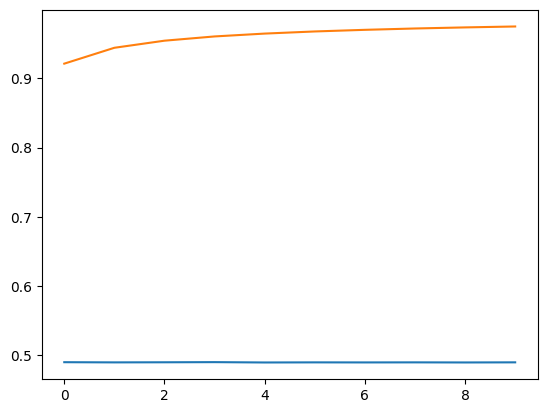

In [46]:
fig, ax = plt.subplots()

ax.plot(list(grouped_results['precision']))
ax.plot(list(grouped_results['generalization']));

# Folds

In [25]:
# Define "folding" algorithm

def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i+n]

traces_concept_names = log_pm4py['case:concept:name'].unique()
rng = np.random.default_rng(123)
rng.shuffle(traces_concept_names)

# Folds of size 5
list(chunks(traces_concept_names, 5))

[array(['3461', '3198', '1372', '423', '1671'], dtype=object),
 array(['1290', '1707', '1140', '2734', '1182'], dtype=object),
 array(['2061', '1482', '62', '3296', '737'], dtype=object),
 array(['380', '884', '526', '2247', '1338'], dtype=object),
 array(['346', '3192', '509', '3156', '2595'], dtype=object),
 array(['2483', '3287', '85', '1378', '662'], dtype=object),
 array(['1221', '3218', '2131', '3179', '909'], dtype=object),
 array(['610', '3347', '1856', '2481', '2482'], dtype=object),
 array(['1223', '1427', '1971', '3220', '878'], dtype=object),
 array(['1957', '120', '246', '224', '2245'], dtype=object),
 array(['2426', '1138', '1947', '554', '1312'], dtype=object),
 array(['3485', '2675', '961', '3018', '539'], dtype=object),
 array(['825', '2747', '1925', '387', '546'], dtype=object),
 array(['3043', '1305', '2112', '664', '391'], dtype=object),
 array(['1521', '1616', '2831', '1848', '115'], dtype=object),
 array(['73', '1863', '138', '2923', '2944'], dtype=object),
 array

In [26]:
%autoreload
from maxes.generators.xes_generator.xes_generator3 import XesGenerator3
from maxes.xes_loader2 import XesLog

# Full
# fold_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
# fold_size_attempts_count = 10
# fold_generation_attempts_count = 10

# Debug
fold_sizes = [1, 10, 100, 1000]
fold_size_attempts_count = 1
fold_generation_attempts_count = 10

results = []

for fold_size in fold_sizes:
    print(f"{fold_size=}")

    for fold_size_attempt in range(fold_size_attempts_count):
        shuffled_traces_concept_names = list(traces_concept_names)
        rng.shuffle(shuffled_traces_concept_names)

        folds = chunks(traces_concept_names, fold_size)

        for fold_index, fold in enumerate(folds):
            filtered_log_df = log_pm4py[log_pm4py['case:concept:name'].isin(fold)]

            print(f"{fold_size=}, {fold_size_attempt=}, {fold_index=}")

            # load log
            log = XesLog()
            log.df = filtered_log_df
            log.update_traces_from_df()

            # Initialize generator
            xes_generator = XesGenerator3(attributes_models=[])
            xes_generator.fit(log)

            for fold_generation_attempt in range(fold_generation_attempts_count):
                generated_log = xes_generator.generate()
                for trace_index, trace in enumerate(generated_log.traces):
                    trace.attributes["concept:name"] = str(trace_index)

                generated_log.update_df(with_trace_attributes=True)
                generated_log_pm4py = generated_log.df

                # evaluate

                fitness = fitness_tbr.apply(generated_log_pm4py, net, im, fm, {'show_progress_bar': False})
                generalization = generalization_tbr.apply(generated_log_pm4py, net, im, fm, {'show_progress_bar': False})
                precision = precision_tbr.apply(generated_log_pm4py, net, im, fm, {'show_progress_bar': False})

                results.append({
                    'fold_size': fold_size,
                    'fold_size_attempt': fold_size_attempt,
                    'fold_index': fold_index,
                    'fold_generation_attempt': fold_generation_attempt,
                    'perc_fit_traces': fitness['perc_fit_traces'],
                    'average_trace_fitness': fitness['average_trace_fitness'],
                    'log_fitness': fitness['log_fitness'],
                    'percentage_of_fitting_traces': fitness['percentage_of_fitting_traces'],
                    'generalization': generalization,
                    'precision': precision
                })

fold_size=1
fold_size=1, fold_size_attempt=0, fold_index=0
fold_size=1, fold_size_attempt=0, fold_index=1
fold_size=1, fold_size_attempt=0, fold_index=2
fold_size=1, fold_size_attempt=0, fold_index=3
fold_size=1, fold_size_attempt=0, fold_index=4
fold_size=1, fold_size_attempt=0, fold_index=5
fold_size=1, fold_size_attempt=0, fold_index=6
fold_size=1, fold_size_attempt=0, fold_index=7
fold_size=1, fold_size_attempt=0, fold_index=8
fold_size=1, fold_size_attempt=0, fold_index=9
fold_size=1, fold_size_attempt=0, fold_index=10
fold_size=1, fold_size_attempt=0, fold_index=11
fold_size=1, fold_size_attempt=0, fold_index=12
fold_size=1, fold_size_attempt=0, fold_index=13
fold_size=1, fold_size_attempt=0, fold_index=14
fold_size=1, fold_size_attempt=0, fold_index=15
fold_size=1, fold_size_attempt=0, fold_index=16
fold_size=1, fold_size_attempt=0, fold_index=17
fold_size=1, fold_size_attempt=0, fold_index=18
fold_size=1, fold_size_attempt=0, fold_index=19
fold_size=1, fold_size_attempt=0, fold

In [27]:
results = pd.DataFrame(results)
results

,fold_size,fold_size_attempt,fold_index,fold_generation_attempt,perc_fit_traces,average_trace_fitness,log_fitness,percentage_of_fitting_traces,generalization,precision
0,1,0,0,0,100.000000,1.000000,1.000000,100.000000,0.054492,0.354167
1,1,0,0,1,100.000000,1.000000,1.000000,100.000000,0.054492,0.354167
2,1,0,0,2,100.000000,1.000000,1.000000,100.000000,0.054492,0.354167
3,1,0,0,3,100.000000,1.000000,1.000000,100.000000,0.054492,0.354167
4,1,0,0,4,100.000000,1.000000,1.000000,100.000000,0.054492,0.354167
...,...,...,...,...,...,...,...,...,...,...
39035,1000,0,3,5,61.914062,0.984360,0.982053,61.914062,0.934741,0.490549
39036,1000,0,3,6,67.773438,0.986299,0.984228,67.773438,0.934831,0.490974
39037,1000,0,3,7,66.015625,0.986083,0.984104,66.015625,0.935342,0.490226
39038,1000,0,3,8,60.546875,0.983500,0.981276,60.546875,0.934922,0.489084


In [28]:
results.groupby(['fold_size']).mean()

,fold_size_attempt,fold_index,fold_generation_attempt,perc_fit_traces,average_trace_fitness,log_fitness,percentage_of_fitting_traces,generalization,precision
fold_size,,,,,,,,,
1,0.0,1755.5,4.5,100.000000,1.000000,1.000000,100.000000,0.041336,0.363726
10,0.0,175.5,4.5,70.295455,0.987716,0.986441,70.295455,0.516796,0.429993
100,0.0,17.5,4.5,62.857407,0.984681,0.982601,62.857407,0.841612,0.485505
1000,0.0,1.5,4.5,63.736563,0.985033,0.982867,63.736563,0.948859,0.489527


In [29]:
grouped_data = results.groupby(['fold_size']).mean()
grouped_data = grouped_data.copy().reset_index()
grouped_data

,fold_size,fold_size_attempt,fold_index,fold_generation_attempt,perc_fit_traces,average_trace_fitness,log_fitness,percentage_of_fitting_traces,generalization,precision
0,1,0.0,1755.5,4.5,100.000000,1.000000,1.000000,100.000000,0.041336,0.363726
1,10,0.0,175.5,4.5,70.295455,0.987716,0.986441,70.295455,0.516796,0.429993
2,100,0.0,17.5,4.5,62.857407,0.984681,0.982601,62.857407,0.841612,0.485505
3,1000,0.0,1.5,4.5,63.736563,0.985033,0.982867,63.736563,0.948859,0.489527


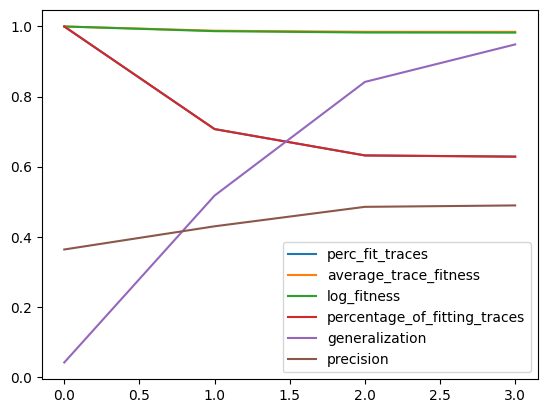

In [113]:
fig, ax = plt.subplots()

grouped_data = results.groupby(['fold_size']).mean()
grouped_data = grouped_data.copy().reset_index()

ax.plot(grouped_data['perc_fit_traces'] / 100, label='perc_fit_traces')
ax.plot(grouped_data['average_trace_fitness'], label='average_trace_fitness')
ax.plot(grouped_data['log_fitness'], label='log_fitness')
ax.plot(grouped_data['percentage_of_fitting_traces'] / 100, label='percentage_of_fitting_traces')
ax.plot(grouped_data['generalization'], label='generalization')
ax.plot(grouped_data['precision'], label='precision')

ax.legend();

In [88]:
log.traces[0].df.columns
trace = log.traces[0]

events = []

for row_index, row in trace.df.iterrows():
    event = {}
    print(f"{row=}")

    for column in trace.df.columns:
        print(f"{column=}")
        value = row[column]
        event[column] = value

    events.append(event)

print(events)

row=call centre                               Brisbane
org:resource                              customer
time:timestamp           1970-01-01 01:00:45+00:00
lifecycle:transition                      complete
concept:name                        incoming claim
case:concept:name                               10
case:description        Simulated process instance
location                                       NaN
duration                                       NaN
outcome                                        NaN
Name: 26, dtype: object
column='call centre'
column='org:resource'
column='time:timestamp'
column='lifecycle:transition'
column='concept:name'
column='case:concept:name'
column='case:description'
column='location'
column='duration'
column='outcome'
row=call centre                                                        NaN
org:resource                                Call Centre Agent Brisbane
time:timestamp                               1970-01-01 01:00:45+00:00
lifecycle:transition

In [87]:
for index, row in trace.df.iterrows():
    print(row)

call centre                               Brisbane
org:resource                              customer
time:timestamp           1970-01-01 01:00:45+00:00
lifecycle:transition                      complete
concept:name                        incoming claim
case:concept:name                               10
case:description        Simulated process instance
location                                       NaN
duration                                       NaN
outcome                                        NaN
Name: 26, dtype: object
call centre                                                        NaN
org:resource                                Call Centre Agent Brisbane
time:timestamp                               1970-01-01 01:00:45+00:00
lifecycle:transition                                             start
concept:name            B check if sufficient information is available
case:concept:name                                                   10
case:description                        